In [47]:
def S(V, B_s):
    return 10 - 7*V/(B_s+V)
    

def NoTreatmentSys(t, y, params):
    mu_T, mu_T_i, k_s, k_nu, p, p_i, C, C_i, G_s, B, B_s, N = params
    T, T_s, V_s = y
    return [S(V_s, B_s) - mu_T*T + T*p*V_s/(C+V_s) - k_s*V_s*T,
            k_s*V_s*T - mu_T_i*T_s - p_i*T_s*V_s/(C_i+V_s),
            N*p_i*T_s*V_s/(C_i+V_s) - k_nu*T*V_s + G_s*V_s/(B+V_s)]

In [48]:
# No treatment scenarios

scenario = 3

if scenario == 1:
    ymax = 20
    G_s = 80.0
    t_max = 14
    n_points = 1000
elif scenario == 2:
    ymax = 20
    G_s = 180.0
    t_max = 1225
    n_points = 3000
elif scenario == 3:
    ymax = 600
    G_s = 330.0
    t_max = 2100
    n_points = 6000

# Article values for parameters
# params = (0.01, # mu_T
#           0.5,  # mu_T_i
#           2.5e-4, # k_s
#           0.01, # k_nu
#           0.5, # p
#           0.5, # p_i
#           188.0, # C
#           188.0, # C_i
#           G_s, # G_s
#           8.0, # B
#           55.0, # B_s
#           10.0, # N
#          )

# Values designed to fit article plots
params_no_treatment = (0.01, # mu_T
                       0.5,  # mu_T_i
                       2.3233e-4, # k_s
                       0.00825, # k_nu
                       0.05, # p
                       0.05, # p_i
                       188.0, # C
                       188.0, # C_i
                       G_s, # G_s
                       12, # B
                       55.0, # B_s
                       10.0, # N
                      )

Solver = ode_solver()
Solver.algorithm = "rk8pd"
Solver.function = NoTreatmentSys
Solver.ode_solve(y_0 = [1000.0, 0.0, 10.0], t_span=[0.0, t_max], params=params_no_treatment, num_points=n_points)

/usr/lib/python3/dist-packages/sage/plot/graphics.py:2327: MatplotlibDeprecationWarning: 
The OldScalarFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  x_formatter = OldScalarFormatter()
/usr/lib/python3/dist-packages/sage/plot/graphics.py:2352: MatplotlibDeprecationWarning: 
The OldScalarFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  y_formatter = OldScalarFormatter()


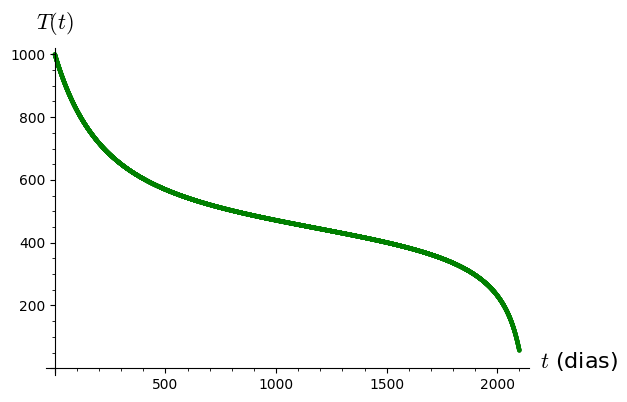

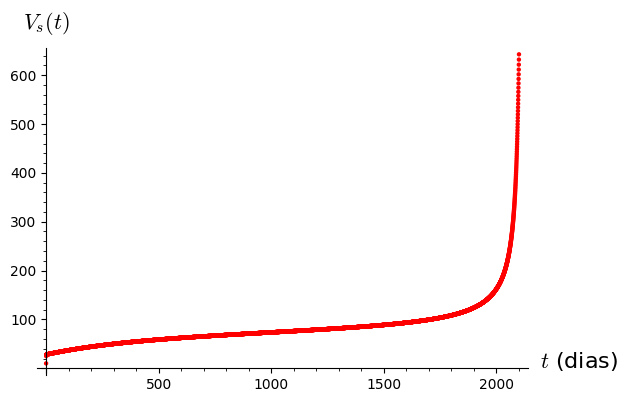

In [50]:
# V_plot = Solver.plot_solution(i=2, color="red", axes_labels=["$t$ (dias)", "$V_s(t)$"], ymin=0, ymax=ymax)
# T_plot = Solver.plot_solution(i=0, color="green", axes_labels=["$t$ (dias)", "$T(t)$"], ymin=0, ymax=1100)
# Solver.plot_solution(i=1, color="blue", axes_labels=["$t$ (dias)", "$T_s(t)$"])

V_plot = list_plot([(state[0], state[1][2]) for state in Solver.solution], color = "red", axes_labels=["$t$ (dias)", "$V_s(t)$"], ymin=0)#, title=f"Infecção com $G_s$ = {int(G_s)}")
T_plot = list_plot([(state[0], state[1][0]) for state in Solver.solution], color = "green", axes_labels=["$t$ (dias)", "$T(t)$"], ymin=0)#, ymax=1100, title=f"Infecção com $G_s$ = {int(G_s)}")
show(T_plot)
show(V_plot)
# V_plot.fontsize(30)
# T_plot.fontsize(30)
# ga = graphics_array((T_plot, V_plot))
# ga.save(f"./cenario_{scenario}.pdf", figsize=[9, 3])#, title=f"Infecção com $G_s$ = {int(G_s)}")

In [4]:
def q_fn(t, q, t_r):
    return 1 if t < t_r else q

def S_0(V, B_s, S_t_0):
    return min(S(V, B_s), S_t_0)
    
def WithTreatmentSys(t, y, params):
    mu_T, mu_T_i, k_s, k_nu, p, p_i, C, C_i, G_s, \
    B, B_s, N, k_r, G_r, q, mu, eta, rho, t_r, t_0, S_T_0 = params
    T, T_s, T_r, V_s, V_r = y
    V = V_s + V_r
    dT = S_0(V, B_s, S_t_0) - mu_T*T + p*T*V/(C+V) - (mu*k_s*V_s + k_r*V_r)*T
    dT_s = mu*k_s*V_s*T - mu_T_i*T_s - p_i*T_s*V/(C_i+V)
    dT_r = k_r*V_r*T - mu_T_i*T_r - p_i*T_r*V/(C_i+V)
    dV_s = rho*q_fn(t, q, t_r)*N*p_i*T_s*V/(C_i+V) - k_nu*T*V_s + eta*G_s*V_s/(B+V)
    dV_r = q_fn(t, q, t_r)*N*p_i*T_r*V/(C_i+V) + (1-q_fn(t, q, t_r))*N*p_i*T_s*V/(C_i+V) - k_nu*T*V_r + G_r*V_r/(B+V)
    return [dT, dT_s, dT_r, dV_s, dV_r]
    
def find_T_pos(solution, T):
    for i, (t, state) in enumerate(solution):
        if state[0] < T:
            return i

In [109]:
case = 1

if case == 1:
    T_trigger = 300
    weeks = 130
elif case == 2:
    T_trigger = 500
    weeks = 270
elif case == 3:
    T_trigger = 200
    weeks = 100



G_s = 330
t_max_no_treatment = 7*400
t_max_from_treatment = 7*weeks
n_points = 3000



Solver_no_treatment = ode_solver()
Solver_no_treatment.algorithm = "rk8pd"
Solver_no_treatment.function = NoTreatmentSys
Solver_no_treatment.ode_solve(y_0 = [1000.0, 0.0, 10.0], t_span=[0.0, t_max_no_treatment], params=params_no_treatment, num_points=n_points)

final_state = find_T_pos(Solver_no_treatment.solution, T_trigger)

init_T = Solver_no_treatment.solution[final_state][1][0]
init_T_s = Solver_no_treatment.solution[final_state][1][1]
init_V_s = Solver_no_treatment.solution[final_state][1][2]

t_0 = Solver_no_treatment.solution[final_state][0]
t_r = 30*7

S_t_0 = S(init_V_s, 55.0) # B_s = 55.0

# # Article values for new parameters
# new_params = (2.5e-4, # k_r
#               0.9995 * G_s, # G_r
#               0.999, # q
#               0.9, # mu
#               0.15, # eta
#               0.05, # rho
#               t_r,
#               t_0,
#               S_t_0,
#              )


2.32e-4
# Values for new parameters desinged to fit article plots
new_params = (2.32e-4, # k_r
              0.9995 * G_s, # G_r
              0.999, # q
              0.9, # mu
              0.15, # eta
              0.05, # rho
              t_r,
              t_0,
              S_t_0,
             )

params_with_treatment = params_no_treatment + new_params

Solver_with_treatment = ode_solver()
Solver_with_treatment.algorithm = "rk8pd"
Solver_with_treatment.function = WithTreatmentSys
Solver_with_treatment.ode_solve(y_0 = [init_T, init_T_s, 0.0, init_V_s, 0.0], t_span=[0, t_max_from_treatment], params=params_with_treatment, num_points=n_points)

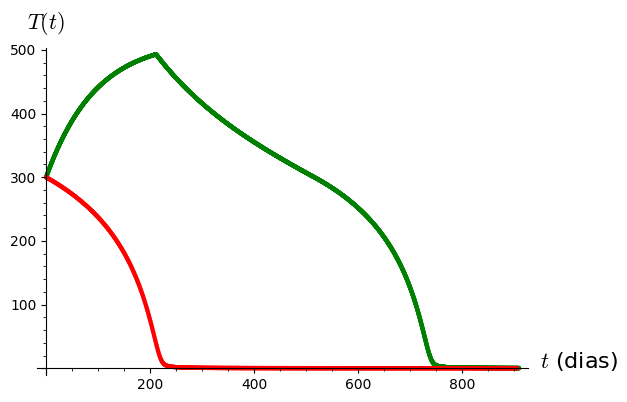

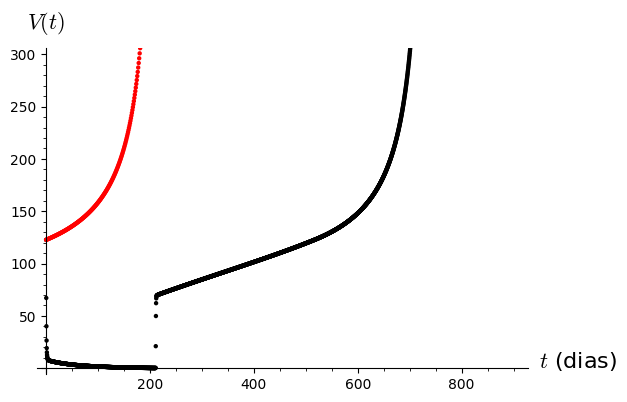

In [113]:
# Solver_with_treatment.plot_solution(i=0, color="green", axes_labels=["$t$", "$T(t)$"])#, ymin=0, ymax=ymax)
# Solver_with_treatment.plot_solution(i=3, color="red", axes_labels=["$t$", "$V_s(t)$"])#, ymin=0, ymax=ymax)
# Solver_with_treatment.plot_solution(i=4, color="black", axes_labels=["$t$", "$V_r(t)$"])#, ymin=0, ymax=ymax)
# Solver_with_treatment.plot_solution(i=1, color="purple", axes_labels=["$t$", "$T_s(t)$"])#, ymin=0, ymax=ymax)
# Solver_with_treatment.plot_solution(i=2, color="orange", axes_labels=["$t$", "$T_r(t)$"])#, ymin=0, ymax=ymax)
T_plot = list_plot([(state[0], state[1][0]) for state in Solver_with_treatment.solution], color = "green", axes_labels=["$t$ (dias)", "$T(t)$"], ymin=0)
V_plot = list_plot([(state[0], state[1][3] + state[1][4]) for state in Solver_with_treatment.solution], color = "black", axes_labels=["$t$ (dias)", "$V(t)$"], ymax=300)
no_treat_T_plot = list_plot([(state[0] - t_0, state[1][0]) for state in Solver_no_treatment.solution[final_state:] if state[0] < t_0 + t_max_from_treatment], color="red")
no_treat_V_plot = list_plot([(state[0] - t_0, state[1][2]) for state in Solver_no_treatment.solution[final_state:] if state[0] < t_0 + t_max_from_treatment], color="red")
show(T_plot + no_treat_T_plot)
show(V_plot + no_treat_V_plot)
# show(no_treat_T_plot)
# show(no_treat_V_plot)
# ga = graphics_array((T_plot, V_plot))
# ga.save(f"./start_treatment_at_T_{T_trigger}.pdf", figsize=[9, 3])#, title=f"Infecção com $G_s$ = {int(G_s)}")
# ga.show()

In [112]:
Solver_with_treatment.solution

[(0,
  [299.97197361732486,
   16.44837611808758,
   0.000000000000000,
   122.69436804724118,
   0.000000000000000]),
 (0.30333333333333334,
  [300.3666539816482, 15.665429016770183, 0.0, 67.18544440363395, 0.0]),
 (0.6066666666666667,
  [301.014050329981, 14.331329761714363, 0.0, 40.17014656209134, 0.0]),
 (0.91, [301.7182116577292, 12.861715683476056, 0.0, 26.537984602169168, 0.0]),
 (1.2133333333333334,
  [302.42736890052663, 11.43276637200668, 0.0, 19.2830794706448, 0.0]),
 (1.5166666666666666,
  [303.13041688562106, 10.11415385780154, 0.0, 15.175719775144266, 0.0]),
 (1.8199999999999998,
  [303.82623831698567, 8.928347172550382, 0.0, 12.705776308221532, 0.0]),
 (2.123333333333333,
  [304.51574334804, 7.876974789097733, 0.0, 11.139851461401559, 0.0]),
 (2.4266666666666663,
  [305.19999801362627, 6.952655602997661, 0.0, 10.102396453673608, 0.0]),
 (2.7299999999999995,
  [305.87986063756347, 6.1444271232824645, 0.0, 9.389730099644757, 0.0]),
 (3.0333333333333328,
  [306.555965462564

In [50]:
WithTreatmentSys(0, [0, 0, 0, 0, 0], params_with_treatment)

[5.16545826408787,
 -0.0500000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000]

In [86]:
x = [1, 2, 3, 4, 5, 6, 7, 8]
y = [p for p in x if p%2==0]

In [87]:
y

[2, 4, 6, 8]